# Fisheries Monitoring

Kaggle competition: https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In this notebook, we will finetune the VGG19 model

In [1]:
import importlib
import utils; importlib.reload(utils)
from utils import *
%matplotlib inline

Using TensorFlow backend.


In [2]:
path = "F:/fishery_monitoring/"

In [5]:
#size of image is height by width
img_size = (300,530)

# Import Data

In [6]:
#set up batches
batch_size = 64
batches = get_batches(path+'train', batch_size=batch_size, target_size = img_size)
val_batches = get_batches(path+'valid', batch_size=batch_size, shuffle=False, target_size = img_size)                                                

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.


In [ ]:
#import training and validation data
train_data = get_data(path+'train', target_size = img_size)
val_data = get_data(path+'valid', target_size = img_size)

#subtract imagenet mean
train_data = preprocess_input(train_data)
val_data = preprocess_input(val_data)


In [7]:
#convert labels to one-hot encoding
train_labels = to_categorical(batches.classes)
val_labels = to_categorical(val_batches.classes)

In [ ]:
save_array(path+'labels/train_labels.dat', train_labels)
save_array(path+'labels/val_labels.dat', val_labels)

In [ ]:
train_labels = load_array(path+'labels/train_labels.dat')
val_labels = load_array(path+'labels/val_labels.dat')

# Finetune VGG19

In [ ]:
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=img_size + (3,))

In [ ]:
vgg_model.compile(Adam(lr=0.001), loss = ['categorical_crossentropy'], metrics=['accuracy'] )

In [ ]:
#save the output of the last conv layer in the VGG19 model
train_vgg = vgg_model.predict(train_data, batch_size = 1)
val_vgg = vgg_model.predict(val_data, batch_size = 1)

In [ ]:
save_array(path+'vgg_features/vgg19_train_feat_big.dat', train_vgg)
save_array(path+'vgg_features/vgg19_val_feat_big.dat', val_vgg)

In [8]:
train_vgg = load_array(path+'vgg_features/vgg19_train_feat_big.dat')
val_vgg = load_array(path+'vgg_features/vgg19_val_feat_big.dat')

# Add Fully Connected Layers

In [9]:
#dropout prob
p=0.8

#create new model on top of vgg output
input_feat = Input(train_vgg.shape[1:])
x = BatchNormalization(axis=1)(input_feat)

x = Dropout(p/2)(x)

x = Flatten()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dropout(p)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dropout(p/2)(x)

x_label = Dense(8, activation='softmax', name='label')(x)

In [10]:
model = Model(input_feat, x_label)
model.compile(Adam(lr=0.001), loss = ['categorical_crossentropy'], metrics=['accuracy'] )

loss_list = []
val_loss_list = []

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 9, 16, 512)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 16, 512)        36        
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 16, 512)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               37749248  
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
__________

# Training

In [12]:
#initialize training with a few epochs at a small learning rate
model.optimizer.lr = 1e-5
model_fit = model.fit(train_vgg, train_labels,  
                      validation_data = (val_vgg,val_labels), 
                      epochs = 2)
loss_list += model_fit.history['loss']
val_loss_list += model_fit.history['val_loss']

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 21s - loss: 2.7096 - acc: 0.1282 - val_loss: 1.6995 - val_acc: 0.4480

Here we train until the training loss drops below the validation loss and the validation loss stops decreasing

epoch:   5 - loss: 1.1935 - val_loss: 0.8584
epoch:  10 - loss: 0.7526 - val_loss: 0.5594
epoch:  15 - loss: 0.5649 - val_loss: 0.4063
epoch:  20 - loss: 0.3892 - val_loss: 0.3205
epoch:  25 - loss: 0.3206 - val_loss: 0.2607
epoch:  30 - loss: 0.2470 - val_loss: 0.2211
epoch:  35 - loss: 0.1924 - val_loss: 0.1910


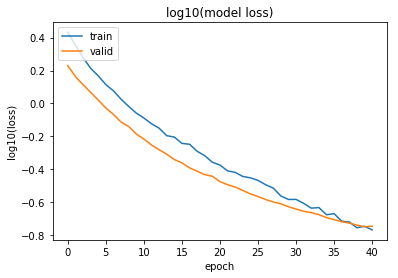

In [13]:
model.optimizer.lr = 1e-3
max_epochs = 100
epoch_count = 0

while (epoch_count < max_epochs and 
       (loss_list[-1] > val_loss_list[-1] or val_loss_list[-2] > val_loss_list[-1])):
        
    model_fit = model.fit(train_vgg, train_labels,  
                          validation_data = (val_vgg,val_labels),
                          epochs = 1,
                          verbose = 0)
    loss_list += model_fit.history['loss']
    val_loss_list += model_fit.history['val_loss']
    epoch_count += 1
    
    if epoch_count % 5 == 0:
        print('epoch: ' + '{:3d}'.format(epoch_count) +
              ' - loss: ' + '{:0.4f}'.format(loss_list[-1]) +
              ' - val_loss: ' + '{:0.4f}'.format(val_loss_list[-1]))
        

plot_log_loss(loss_list, val_loss_list)


# Make Predictions

In [ ]:
#import test data
test_batches = get_batches(path+'test', shuffle = False, batch_size=1, class_mode=None, target_size=img_size)
test_data = np.concatenate([test_batches.next() for i in range(test_batches.samples)])
test_data = preprocess_input(test_data)

In [ ]:
#get vgg features from test data
test_vgg = vgg_model.predict(test_data, batch_size=1)

In [ ]:
save_array(path+'vgg_features/vgg19_test_feat_big.dat', test_vgg)

In [ ]:
test_vgg = load_array(path+'vgg_features/vgg19_test_feat_big.dat')

In [ ]:
#make predictions from the fully connected layers
test_preds = model.predict(test_vgg)
test_filenames = list(map(lambda x: x.split('\\')[-1], test_batches.filenames))

In [ ]:
#clip data to avoid overconfidence
test_preds_clip = do_clip(test_preds,0.82)

In [ ]:
#create dataframe of predictions and write to csv
d = datetime.now()
out_name = 'outputs/vgg19big_' + d.strftime('%m_%d_%H_%M.csv')
test_preds_df = pd.DataFrame(test_preds_clip, columns = ["ALB","BET","DOL","LAG","NoF","OTHER","SHARK","YFT"])
test_preds_df['image'] = test_filenames 
test_preds_df.to_csv(out_name, index = False, 
                     columns = ["image","ALB","BET","DOL","LAG","NoF","OTHER","SHARK","YFT"])